# Image Classification using Pre-trained model

## Step 1- Download the model

In [ ]:
!omz_downloader --name inception-resnet-v2-tf

## Step 2 - Import the libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core
from pathlib import Path
from IPython.display import Markdown

## Step 3 - Convert the model to IR

In [2]:
# The paths of the source and converted models
model_path = Path("/home/chetan/public/inception-resnet-v2-tf/inception_resnet_v2.pb")
ir_path = Path(model_path).with_suffix(".xml")

In [3]:
# Construct the command for Model Optimizer
mo_command = f"""mo
                 --input_model "{model_path}"
                 --input_shape "[1,299,299,3]"
                 --mean_values="[127.5,127.5,127.5]"
                 --scale_values="[127.5]"
                 --data_type FP16
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --input_model "/home/chetan/public/inception-resnet-v2-tf/inception_resnet_v2.pb" --input_shape "[1,299,299,3]" --mean_values="[127.5,127.5,127.5]" --scale_values="[127.5]" --data_type FP16 --output_dir "/home/chetan/public/inception-resnet-v2-tf"`

In [ ]:
# Run Model Optimizer
print("Exporting TensorFlow model to IR... This may take a few minutes.")
! $mo_command

## Load the model

In [4]:
# Load the converted model
ie = Core()
model = ie.read_model(model="/home/chetan/public/inception-resnet-v2-tf/inception_resnet_v2.xml")
compiled_model = ie.compile_model(model=model, device_name="CPU")

## Get Model Information

In [14]:
input_layer = next(iter(compiled_model.inputs))
output_layer = next(iter(compiled_model.outputs))
network_input_shape = input_layer.shape

## Load an Image

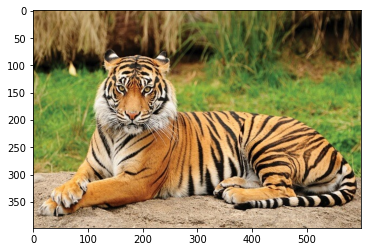

In [15]:
## # The MobileNet network expects images in RGB format
image = cv2.cvtColor(cv2.imread(filename="data/Bengal-tiger-1.jpg"), code=cv2.COLOR_BGR2RGB)

# Resize image to network input image shape
resized_image = cv2.resize(src=image, dsize=(299, 299))

# Transpose image to network input shape
input_image = np.expand_dims(resized_image, 0)

plt.imshow(image);

## Inference

In [26]:
# Option 1

result = compiled_model([input_image])[output_key]
result_index = np.argmax(result)
print('Result index', result_index)

# Convert the inference result to a class name.
imagenet_classes = open("/home/chetan/public/inception-resnet-v2-tf/labels.txt").read().splitlines()
print('Predicted class:', imagenet_classes[result_index])

Result index 293
Predicted class: tiger


In [25]:
# Option 2
request = compiled_model.create_infer_request()
request.infer(inputs={input_layer.any_name: input_image})
result = request.get_output_tensor(output_layer.index).data
result_index = np.argmax(result)

# Convert the inference result to a class name.
imagenet_classes = open("/home/chetan/public/inception-resnet-v2-tf/labels.txt").read().splitlines()
print('Predicted class:', imagenet_classes[result_index])

Predicted class: tiger
